In [829]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import face_recognition
from pathlib import Path
import platform
from datetime import datetime
import filedate
from PIL import Image
import glob
import time
import math

In [1161]:
# initial facial feature detection cascades
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")
mouth_cascade = cv2.CascadeClassifier("haarcascade_mcs_mouth.xml")
glasses_cascade = cv2.CascadeClassifier("haarcascade_eye_tree_eyeglasses.xml")

In [175]:
try:
    os.mkdir('temp')
except:
    print('temp already exists')

temp already exists


In [449]:
base_face = face_recognition.load_image_file('May23/may262023.jpg')
base_face_encoding = face_recognition.face_encodings(base_face)[0]

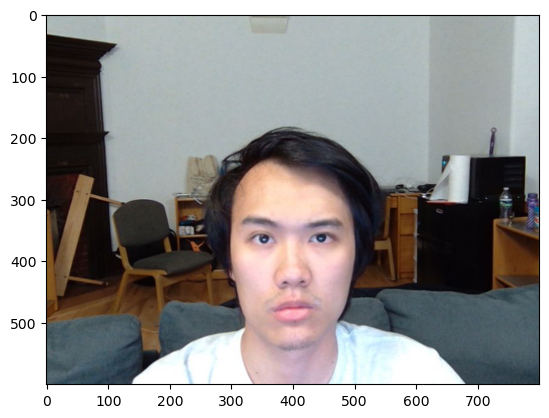

In [450]:
plt.imshow(base_face)

In [1216]:
def extract_features(img_path):
    img = cv2.imread(img_path)
        
    # detect multiscale only works on grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale (gray, 
                                          scaleFactor = 1.1, 
                                          minNeighbors = 6)
    
    # Defining and drawing the rectangle around the face
    best_face_match = -1 # face match score. max: 100

    # position (my_x, my_y) and dimensions (my_w, my_h) of bounding box for face
    my_x = my_y = my_w = my_h = -1
    
    counter = 0
    
    if len(faces) < 1:
        raise Exception("No faces detected.")   
    elif len(faces) == 1:
        my_x, my_y, my_w, my_h = faces[0]
    else: # for multiple faces
        for (x , y,  w,  h) in faces:
            try: # in case face_recongition doesn't find a face in the region of interest (roi)

                # crop the roi for the potential face, so we can do face matching
                temp_img_name = 'temp/temp' + str(counter) + '.jpg'
                cv2.imwrite(temp_img_name, img[y:(y + h), x:(x + w)])

                # compare candidate unknown face to base face
                unknown_picture = face_recognition.load_image_file(temp_img_name)
                
                #, known_face_locations=[(0, 0, w, h)]
                unknown_face_encoding = face_recognition.face_encodings(unknown_picture)[0]
                #print(unknown_face_encoding)
                
                face_distances = face_recognition.face_distance([base_face_encoding], unknown_face_encoding)
                face_match = (1 - face_distances) * 100

                # keep face with highest match to base face
                if face_match > best_face_match:
                    my_x, my_y, my_w, my_h = x, y, w, h
                    best_face_match = face_match

            except Exception as e:
                print(e)
            counter += 1
    
        # if no faces match, just guess the largest face. 
        # assumption: the person doing the photo a day will be the "main" face
        if my_x == -1:
            largest_face_size = -1
            my_x, my_y, my_w, my_h = x, y, w, h
            
            for (x , y,  w,  h) in faces:
                face_size = w * h
                if face_size > largest_face_size:
                    my_x, my_y, my_w, my_h = x, y, w, h
                    largest_face_size = face_size
        
    # draw rectangle around matched face
    cv2.rectangle(img, (my_x,my_y) ,(my_x+my_w, my_y+my_h), (0,255,0), 3)
        
    # the regions of interest(roi) is a bounding box around the desired face
    roi_gray=gray[my_y:(my_y+my_h), my_x:(my_x+my_w)]
    roi_color=img[my_y:(my_y+my_h), my_x:(my_x+my_w)]
    
    # rois for lower half of the face to make mouth detection more accurate
    lower_roi_gray = gray[my_y + int(.6 * my_h):(my_y+my_h), my_x:(my_x+my_w)]
    lower_roi_color=img[my_y + int(.6 * my_h):(my_y+my_h), my_x:(my_x+my_w)]
    
    # detect mouth
    mouths, mouth_reject_lvls, mouth_lvl_weights = mouth_cascade.detectMultiScale3(lower_roi_gray, 
                                           scaleFactor = 1.2, 
                                           minNeighbors = 3,
                                           outputRejectLevels=True)
    
    if len(mouths) < 1:
        # guess lower roi box as lips if better bounding box could not be detected
        abs_mouth = (my_x + int(my_w/2), my_y + int(.6 * my_h) + int((.4*my_h)/ 2))
    else:
        # find most likely candidate for mouth
        idx = np.argmax(mouth_lvl_weights)

        # find bounding box for mouth
        mx, my, mw, mh = tuple(mouths[idx])

        # find center of the mouth for alignment purposes
        mouth_center = (mx + int(mw/2), my + int(mh/2))
        # absolute position of the mouth
        abs_mouth = (my_x + mouth_center[0], my_y + int(2*my_h/3) + mouth_center[1])
    
    # rois for upper half of the face to make eye detection more accurate
    upper_roi_gray = gray[my_y:(my_y+int(.75*my_h)), my_x:(my_x+my_w)]
    upper_roi_color=img[my_y:(my_y+int(.75*my_h)), my_x:(my_x+my_w)]

    # detect eyes. eye_cascade works better without glasses
    eyes, eye_reject_lvls, eye_lvl_weights = eye_cascade.detectMultiScale3(upper_roi_gray, 
                                        scaleFactor = 1.1, 
                                        minNeighbors = 8,
                                        outputRejectLevels=True)

    if len(eyes) < 2:
        # usually, the problem is glasses are being worn. check if we can do better with glasses cascade
        eyes, eye_reject_lvls, eye_lvl_weights = glasses_cascade.detectMultiScale3(upper_roi_gray, 
                                        scaleFactor = 1.04, 
                                        minNeighbors = 1,
                                        outputRejectLevels=True)
        # if eyes still cannot be detected after using 2 cascades, throw error
        
        if len(eyes) < 2:
            print('too few eyes: ' + str(len(eyes)))
            raise Exception('Too few eyes found in facial region of interest.')
        
    # find most likely 2 candidates for eyes
    best_idx = np.argsort(eye_lvl_weights)[len(eye_lvl_weights) - 2:]
    
    index = 0
    for i in best_idx:
        ex, ey, ew, eh = eyes[i]
        if index == 0:
            eye_1 = (ex, ey, ew, eh)
        elif index == 1:
            eye_2 = (ex, ey, ew, eh)
        cv2.rectangle(roi_color, (ex,ey) ,(ex+ew, ey+eh), (0,0,255), 3)
        index = index + 1
    
    # distinguish between left and right eye
    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1
    
    # get centers of left and right eyes
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    left_eye_x = left_eye_center[0] 
    left_eye_y = left_eye_center[1]

    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    right_eye_x = right_eye_center[0]
    right_eye_y = right_eye_center[1]

    # mark center of eyes
    cv2.circle(roi_color, left_eye_center, 5, (255, 0, 0) , -1)
    cv2.circle(roi_color, right_eye_center, 5, (255, 0, 0) , -1)
    
    # mark line between eyes
    cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)
    
    if left_eye_y > right_eye_y:
        A = (right_eye_x, left_eye_y)
        # Integer -1 indicates that the image will rotate in the clockwise direction
        direction = -1 
    else:
        A = (left_eye_x, right_eye_y)
        # Integer 1 indicates that image will rotate in the counter clockwise  
        direction = 1 

    cv2.circle(roi_color, A, 5, (255, 0, 0), -1)

    cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)
    cv2.line(roi_color,left_eye_center, A,(0,200,200),3)
    cv2.line(roi_color,right_eye_center, A,(0,200,200),3)
    
    delta_x = max(right_eye_x - left_eye_x, 1) # avoid divide by 0??
    delta_y = right_eye_y - left_eye_y
    eye_dist = np.sqrt((delta_x * delta_x) + (delta_y * delta_y))
    
    # get angle that eye is offset from level (in degrees)
    angle = np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi
    
    # need 3 points for alignment. use abs_mouth, abs_left_eye, abs_right_eye
    # absolute positions for eyes based on the original image, rather than the roi's
    abs_left_eye = (my_x + left_eye_x, my_y + left_eye_y)
    abs_right_eye = (my_x + right_eye_x, my_y + right_eye_y)
    
    # mark center of lips
    cv2.circle(img, abs_mouth, 5, (255, 0, 0) , -1)
        
    # validate that mouth is farther from an eye than the eyes are from each other
    # otherwise, it's too likely that an eye was misclassified as a mouth
    # TODO: double check whether this validation makes sense on average
    mouth_eye_dist = min(math.dist(abs_left_eye, abs_mouth), math.dist(abs_right_eye, abs_mouth))
    if mouth_eye_dist < math.dist(abs_left_eye, abs_right_eye):
        raise Exception("likely misclassified mouth as eyes")

    return (img, angle, abs_left_eye, abs_right_eye, abs_mouth)

In [1217]:
# make the eyes of the input image level
def level(img_path):
    _, angle, _, _, _ = extract_features(img_path)
    
    img = cv2.imread(img_path)
    # Width and height of the image
    h, w = img.shape[:2]
    # Calculating a center point of the image
    center = (w // 2, h // 2)
    
    # Defining a matrix M and calling
    # cv2.getRotationMatrix2D method
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    
    # Applying the rotation to our image using the cv2.warpAffine method
    rotated = cv2.warpAffine(img, M, (w, h))
    
    return rotated

In [1218]:
def crop(img, border = 20):
    cropped = img[border:-border, border:-border] 
    cropped = cv2.resize(cropped, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    return cropped

In [1139]:
img, angle, abs_left_eye, abs_right_eye, abs_mouth = extract_features('2023/August23/august42023.jfif')

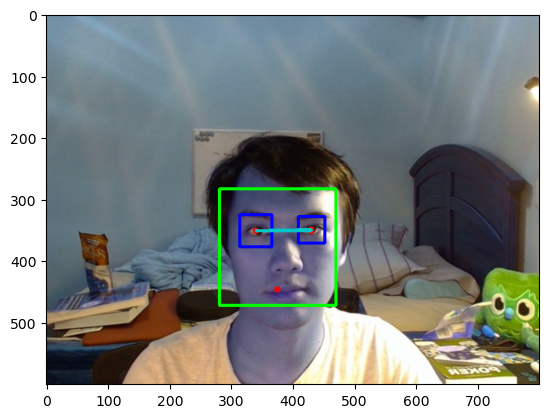

In [1140]:
plt.imshow(img)

In [1137]:
rotated = level('May23/may262023.jpg')

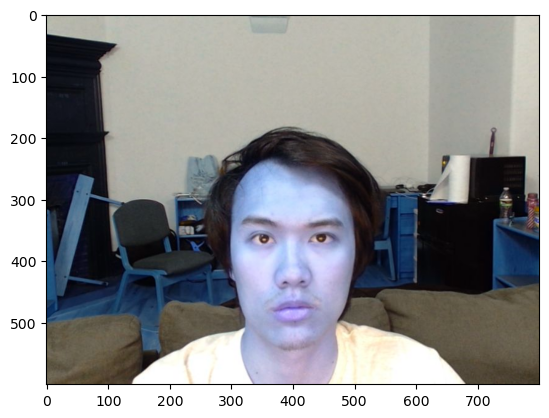

In [888]:
plt.imshow(rotated)

In [889]:
cropped = crop(rotated)

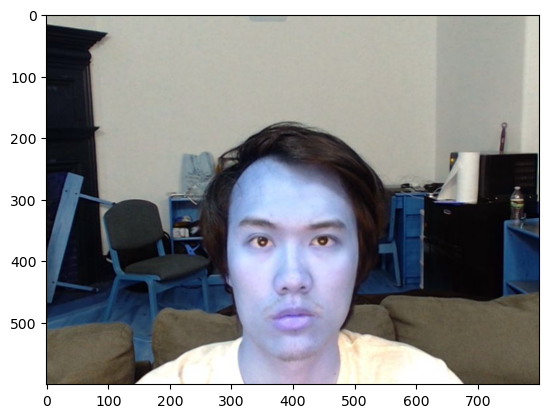

In [1028]:
plt.imshow(cropped)

In [891]:
cv2.imwrite('base.jpg', rotated)

True

In [892]:
img, angle, abs_left_eye, abs_right_eye, abs_mouth = extract_features('base.jpg')

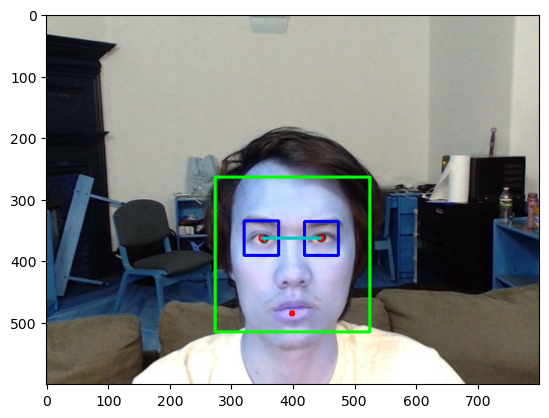

In [893]:
plt.imshow(img)

In [1034]:
img.shape

(600, 800, 3)

In [1219]:
def match(base_img_path, img_path):
    
    b = cv2.imread(base_img_path)
    i = cv2.imread(img_path)
    
    # extract features from the base image
    b_img, b_angle, b_leye, b_reye, b_mouth = extract_features(base_img_path)
    
    # extract features from the target image
    img, angle, leye, reye, mouth = extract_features(img_path)
    
    # use 3 key points from each image for alignment
    dst_tri = np.array([b_leye, b_reye, b_mouth]).astype(np.float32)
    src_tri = np.array([leye, reye, mouth]).astype(np.float32)
    
    # calculate the affine transformation for alignment
    warp_mat = cv2.getAffineTransform(src_tri, dst_tri)
    
    # apply the transformation for alignment
    src_img = cv2.imread(img_path)
    warpped = cv2.warpAffine(src_img, warp_mat, (src_img.shape[1], src_img.shape[0]))
    
    
    # double check that a face can still be detected post warp, in case excess distortion occurs
    gray = cv2.cvtColor(warpped, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale (gray, 
                                          scaleFactor = 1.1, 
                                          minNeighbors = 6)    
    if len(faces) < 1:
        raise Exception("No faces detected post warp.")  
        
    return warpped

In [1141]:
test = match('base.jpg', '2023/March23/march52023.jpeg')

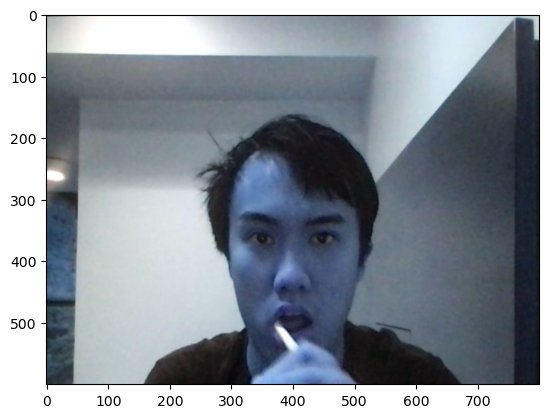

In [1142]:
plt.imshow(test)

In [903]:
def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime

In [904]:
# set the creation date of a file
def set_date(file_path, ctime):
    os.utime(file_path, (ctime, ctime))

In [1211]:
# TEST CODE for 1 directory
directory = '2023/July23'
for filename in os.listdir(directory):
    try:
        f = os.path.join(directory, filename)
        
        input_img = cv2.imread(f)
        print (input_img.shape)
        
        if input_img.shape[0] != 600 and input_img.shape != 800:
            input_img = cv2.resize(input_img, (800, 600))
            print('new size: ' + str(input_img.shape))
            cv2.imwrite('temp/resized.jpg', input_img)
            f = 'temp/resized.jpg'
        
        edited = match('base.jpg', f)
        output_name = 'testrun/' + Path(f).stem + '.jpg'
        edited = crop(edited)
        cv2.imwrite(output_name, edited)
        
        set_date(output_name, creation_date(f))
    except Exception as e:
        print(f)
        print(e)

(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
2023/July23/july12023.jfif
No faces detected.
(600, 800, 3)
list index out of range
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
2023/July23/july162023.jfif
No faces detected.
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(3088, 2316, 3)
new size: (600, 800, 3)
temp/resized.jpg
likely misclassified mouth as eyes
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
list index out of range
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)


In [1039]:
# test code for directory traversal
for filename in glob.iglob('2023/**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        try:
            #print(filename)
            output_name = 'output/' + os.path.splitext(filename)[0] + '.jpg'
            print(output_name)
        except Exception as e:
            print(f)
            print(e)

output/2023/February23/february272023.jpg
output/2023/February23/february12023.jpg
output/2023/February23/february242023.jpg
output/2023/February23/february252023.jpg
output/2023/February23/february262023.jpg
output/2023/February23/february102023.jpg
output/2023/February23/february112023.jpg
output/2023/February23/february232023.jpg
output/2023/February23/february222023.jpg
output/2023/February23/february172023.jpg
output/2023/February23/february162023.jpg
output/2023/February23/february62023.jpg
output/2023/February23/february72023.jpg
output/2023/February23/february132023.jpg
output/2023/February23/february122023.jpg
output/2023/February23/february192023.jpg
output/2023/February23/february182023.jpg
output/2023/February23/february282023.jpg
output/2023/February23/february22023.jpg
output/2023/February23/february32023.jpg
output/2023/February23/february82023.jpg
output/2023/February23/february92023.jpg
output/2023/February23/february52023.jpg
output/2023/February23/february42023.jpg
o

In [1027]:
try:
    os.mkdir('output')
except:
    print('directory called output already exists')

directory called output already exists


In [1220]:
# apply match function to each picture. output files will be in a similar directory structure as the input structure
# and will retain the same creation time information for sorting purposes
error_count = 0
for filename in glob.iglob('2023/**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        try:
            
            # if input image is not 600 by 800, resize before processing
            # TODO: modularize this
            input_img = cv2.imread(filename)

            if input_img.shape[0] != 600 and input_img.shape != 800:
                input_img = cv2.resize(input_img, (800, 600))
                print('new size: ' + str(input_img.shape))
                cv2.imwrite('temp/resized.jpg', input_img)
                filename = 'temp/resized.jpg'
        
            
            edited = match('base.jpg', filename)
            output_name = 'output/' + os.path.splitext(filename)[0] + '.jpg'
            
            # create directory if desired children directories do not exist
            os.makedirs(os.path.dirname(output_name), exist_ok=True)
            
            # shrink the black edges slightly. (default: 20 pixels from each side)
            edited = crop(edited)
            cv2.imwrite(output_name, edited)
            set_date(output_name, creation_date(filename))
        except Exception as e:
            error_count += 1
            print(filename)
            print(e)
print('number of errors: ' + str(error_count))

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
new size: (600, 800, 3)
list index out of range
too few eyes: 1
temp/resized.jpg
Too few eyes found in facial region of interest.
list index out of range
list index out of range
list index out of range
list index out of range
2023/March23/march222023.jfif
No faces detected.
too few eyes: 1
2023/March23/march172023.jfif
Too few eyes found in facial region of interest.
list index out of range
list index out of range
2023/July23/july12023.jfif
No faces detected.
list index out of range
2023/July23/july162023.jfif
No faces detected.
new size: (600, 800, 3)
temp/resized.jpg
likely misclassified mouth as eyes
list index out of range
2023/June23/june302023.jfif
N

In [1221]:
# create an array of image paths, searching recursively, sorted by creation date

dir_name = 'output/'
# Get list of all files only in the given directory
img_path_array = filter( os.path.isfile,
                        glob.glob(dir_name + '**', recursive=True) )


# Sort list of files based on last modification time in ascending order
img_path_array = sorted( img_path_array,
                        key = os.path.getmtime)
# Iterate over sorted list of files and print file path 
# along with last modification time of file 
for file_path in img_path_array:
    timestamp_str = time.strftime(  '%m/%d/%Y :: %H:%M:%S',
                                time.gmtime(os.path.getmtime(file_path))) 
    print(timestamp_str, ' -->', file_path)
    

01/01/2023 :: 04:02:48  --> output/2023/January23/january12023.jpg
01/02/2023 :: 04:03:12  --> output/2023/January23/january22023.jpg
01/03/2023 :: 04:08:32  --> output/2023/January23/january32023.jpg
01/04/2023 :: 04:09:44  --> output/2023/January23/january42023.jpg
01/05/2023 :: 04:09:54  --> output/2023/January23/january52023.jpg
01/06/2023 :: 04:05:12  --> output/2023/January23/january62023.jpg
01/07/2023 :: 04:02:52  --> output/2023/January23/january72023.jpg
01/08/2023 :: 04:09:52  --> output/2023/January23/january82023.jpg
01/09/2023 :: 04:14:32  --> output/2023/January23/january92023.jpg
01/10/2023 :: 04:42:06  --> output/2023/January23/january102023.jpg
01/11/2023 :: 18:40:26  --> output/2023/January23/january112023.jpg
01/12/2023 :: 04:20:56  --> output/2023/January23/january122023.jpg
01/13/2023 :: 04:30:06  --> output/2023/January23/january132023.jpg
01/14/2023 :: 04:59:38  --> output/2023/January23/january142023.jpg
01/15/2023 :: 16:12:02  --> output/2023/January23/january

In [1222]:
img_array = []
for filename in img_path_array:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 10, size)

# go through each output image in creation date order, and add to the video
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# debugging + testing

In [1225]:
# detect multiscale only works on grayscale
img = cv2.imread('2023/August23/august42023.jfif') 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces= face_cascade.detectMultiScale (gray, 
                                      scaleFactor = 1.1, 
                                      minNeighbors = 3)

# Defining and drawing the rectangle around the face
best_face_match = -1 # face match score. max: 100

my_x = my_y = my_w = my_h = -1

counter = 0

if len(faces) < 1:
    raise Exception("No faces detected.")   
elif len(faces) == 1:
    my_x, my_y, my_w, my_h = faces[0]
else: # for multiple faces
    for (x , y,  w,  h) in faces:
        try: # in case face_recongition doesn't find a face in the region of interest (roi)

            # crop the roi for the potential face, so we can do face matching
            temp_img_name = 'temp/temp' + str(counter) + '.jpg'
            cv2.imwrite(temp_img_name, img[y:(y + h), x:(x + w)])

            # compare candidate unknown face to base face
            unknown_picture = face_recognition.load_image_file(temp_img_name)

            #, known_face_locations=[(0, 0, w, h)]
            unknown_face_encoding = face_recognition.face_encodings(unknown_picture)[0]
            #print(unknown_face_encoding)

            face_distances = face_recognition.face_distance([base_face_encoding], unknown_face_encoding)
            face_match = (1 - face_distances) * 100

            # keep face with highest match to base face
            if face_match > best_face_match:
                my_x, my_y, my_w, my_h = x, y, w, h
                #print("found")
                best_face_match = face_match

        except Exception as e:
            print(e)
            #pass
        counter += 1

    # if no faces match, just guess
    if my_x == -1:
        my_x, my_y, my_w, my_h = x, y, w, h

print(faces)
# draw rectangle around matched face
cv2.rectangle(img, (my_x,my_y) ,(my_x+my_w, my_y+my_h), (0,255,0), 3)

# each region of interest(roi) is a bounding box around the desired face
roi_gray=gray[my_y:(my_y+my_h), my_x:(my_x+my_w)]
roi_color=img[my_y:(my_y+my_h), my_x:(my_x+my_w)]

# detect mouth

lower_roi_gray = gray[my_y + int(.6*my_h):(my_y+my_h), my_x:(my_x+my_w)]
lower_roi_color=img[my_y + int(.6*my_h):(my_y+my_h), my_x:(my_x+my_w)]

cv2.rectangle(img, (my_x, my_y + int(.6*my_h)), (my_x+my_w, my_y+my_h), (0, 255, 0), 3)

mouths, mouth_reject_lvls, mouth_lvl_weights = mouth_cascade.detectMultiScale3(lower_roi_gray, 
                                       scaleFactor = 1.1, 
                                       minNeighbors = 8,
                                       outputRejectLevels=True)

if len(mouths) < 1:
    # guess lower roi as lips if better bounding box could not be detected
    abs_mouth = (my_x + int(my_w/2), my_y + int(2*my_h/3) + int((.4*my_h)/ 2))
else:
    # find most likely candidate for mouth
    idx = np.argmax(mouth_lvl_weights)

    # find bounding box for mouth
    mx, my, mw, mh = tuple(mouths[idx])

    # find center of the mouth for alignment purposes
    mouth_center = (mx + int(mw/2), my + int(mh/2))
    abs_mouth = (my_x + mouth_center[0], my_y + int(2*my_h/3) + mouth_center[1])
    
upper_roi_gray = gray[my_y:(my_y+int(.75*my_h)), my_x:(my_x+my_w)]
upper_roi_color=img[my_y:(my_y+int(.75*my_h)), my_x:(my_x+my_w)]

# detect eyes
eyes, eye_reject_lvls, eye_lvl_weights = eye_cascade.detectMultiScale3(upper_roi_gray, 
                                    scaleFactor = 1.1, 
                                    minNeighbors = 8,
                                    outputRejectLevels=True)

if len(eyes) < 2:
    eyes, eye_reject_lvls, eye_lvl_weights = glasses_cascade.detectMultiScale3(upper_roi_gray, 
                                    scaleFactor = 1.04, 
                                    minNeighbors = 2,
                                    outputRejectLevels=True)
    if len(eyes) < 2:
        print('too few eyes: ' + str(len(eyes)))
        raise Exception('Too few eyes found in facial region of interest.')

# find most likely candidates for eyes
best_idx = np.argsort(eye_lvl_weights)[len(eye_lvl_weights) - 2:]

index = 0
for i in best_idx:
    ex, ey, ew, eh = eyes[i]
    if index == 0:
        eye_1 = (ex, ey, ew, eh)
    elif index == 1:
        eye_2 = (ex, ey, ew, eh)
    cv2.rectangle(roi_color, (ex,ey) ,(ex+ew, ey+eh), (0,0,255), 3)
    index = index + 1

# distinguish between left and right eye
if eye_1[0] < eye_2[0]:
    left_eye = eye_1
    right_eye = eye_2
else:
    left_eye = eye_2
    right_eye = eye_1

# get centers of left and right eyes
left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
left_eye_x = left_eye_center[0] 
left_eye_y = left_eye_center[1]

right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
right_eye_x = right_eye_center[0]
right_eye_y = right_eye_center[1]

# mark center of eyes
cv2.circle(roi_color, left_eye_center, 5, (255, 0, 0) , -1)
cv2.circle(roi_color, right_eye_center, 5, (255, 0, 0) , -1)

# mark line between eyes
cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)

if left_eye_y > right_eye_y:
    A = (right_eye_x, left_eye_y)
    # Integer -1 indicates that the image will rotate in the clockwise direction
    direction = -1 
else:
    A = (left_eye_x, right_eye_y)
    # Integer 1 indicates that image will rotate in the counter clockwise  
    direction = 1 

cv2.circle(roi_color, A, 5, (255, 0, 0), -1)

cv2.line(roi_color,right_eye_center, left_eye_center,(0,200,200),3)
cv2.line(roi_color,left_eye_center, A,(0,200,200),3)
cv2.line(roi_color,right_eye_center, A,(0,200,200),3)

delta_x = right_eye_x - left_eye_x
delta_y = right_eye_y - left_eye_y
eye_dist = np.sqrt((delta_x * delta_x) + (delta_y * delta_y))

# get angle that eye is offset from level (in degrees)
angle=np.arctan(delta_y/delta_x)
angle = (angle * 180) / np.pi

# need 3 points for alignment
# absolute positions based on the original image, rather than the roi's
abs_left_eye = (my_x + left_eye_x, my_y + left_eye_y)
abs_right_eye = (my_x + right_eye_x, my_y + right_eye_y)
#abs_mouth = (my_x + mouth_center[0], my_y +  + int(2*my_h/3) + mouth_center[1])

# mark center of lips
cv2.circle(img, abs_mouth, 5, (255, 0, 0) , -1)

list index out of range
list index out of range
[[ 50 355  54  54]
 [281 283 189 189]]


array([[[115, 148, 168],
        [115, 148, 168],
        [114, 147, 167],
        ...,
        [141, 157, 164],
        [143, 156, 164],
        [143, 156, 164]],

       [[115, 148, 168],
        [115, 148, 168],
        [114, 147, 167],
        ...,
        [141, 157, 164],
        [143, 156, 164],
        [143, 156, 164]],

       [[115, 148, 168],
        [115, 148, 168],
        [114, 147, 167],
        ...,
        [141, 157, 164],
        [143, 156, 164],
        [143, 156, 164]],

       ...,

       [[ 10,  18,  31],
        [ 10,  18,  31],
        [ 10,  18,  31],
        ...,
        [ 89,  68,  47],
        [ 88,  64,  44],
        [ 87,  63,  41]],

       [[  9,  17,  30],
        [  9,  17,  30],
        [  9,  17,  30],
        ...,
        [ 92,  68,  46],
        [ 91,  64,  43],
        [ 91,  65,  41]],

       [[  8,  16,  29],
        [  8,  16,  29],
        [  8,  16,  29],
        ...,
        [ 91,  67,  43],
        [ 93,  65,  41],
        [ 94,  66,  42]]

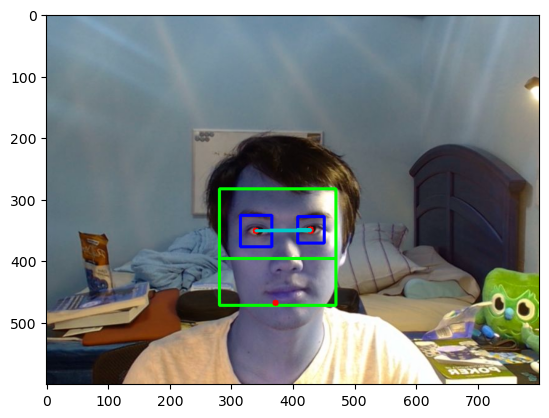

In [1226]:
plt.imshow(img)